# Todays News Trends

### Program gets the current to headlines from 
*All News Media*
### and performs sentiment analysis on the news to identify the current sentiment.

In [86]:
# Dependencies
import string
import tweepy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import time
import math

import requests

from pprint import pprint

import seaborn as sns

%matplotlib inline

# News API
import newsapi
from newsapi.newsapi_client import NewsApiClient
from newsapi.articles import Articles
from newsapi.sources import Sources

# NLTK
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist

#word cloud
from wordcloud import WordCloud

In [4]:
# Twitter API Keys
from config import (consumer_key, consumer_secret, access_token, access_token_secret)
#News API Keys
from config import newapi_key

In [5]:
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

#from config import (consumer_key, consumer_secret,
#                    access_token, access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

# Init
newsapi = NewsApiClient(api_key='4b7e7bb7670e40f788f92667a6a2dd64')
newsapi_Articles = Articles(API_KEY=newapi_key)
newsapi_Sources = Sources(API_KEY=newapi_key)

### Method: getCurrentHeadlines() 
### Get the top headlines from newsapi. 
Default value country=US, lanuage=english, page_size=100 (max allowed) <br/>
Other paramers like q (query), sources, categories and pages can be passed in.

##### Note: country and category params cannot be used with sources param
*Category possible values:* 'business','entertainment','general','health','science','sports','technology'

**Returns a Dictionary** <br/>
Dictionary["totalResults"] key will provide the total number of articles that were returned by newsapi. <br/>
The method returns only Max of 500 articles <br/>

In [6]:
def getCurrentHeadlines(q=None, 
                        sources=None, 
                        language='en', 
                        country='us', 
                        category=None, 
                        page_size=100, 
                        page=None):
    if(sources != None):
        country = None
        category = None
        
    print(f"Calling => getCurrentHeadlines(q={q}, \n\
                                sources={sources},\n\
                                language={language},\n\
                                country={country},\n\
                                category={category},\n\
                                page_size={page_size},\n\
                                page={page})")

    results = newsapi.get_top_headlines(q, 
                                              sources, 
                                              language, 
                                              country, 
                                              category, 
                                              page_size, 
                                              page)
    results_count = results['totalResults'] 
    # return value
    top_headlines = results['articles']
    
    # the first 100 has already been pulled in the first call, 
    # so start pulling from page 2
    loopcount = int(results_count / 100)
    page = 2
    
    while(loopcount > 0):
        #print('INSIDE LOOP')
        #print(f"output list size = {len(top_headlines)}")
        
        results = None
        results = newsapi.get_top_headlines(q, 
                                          sources, 
                                          language, 
                                          country, 
                                          category, 
                                          page_size, 
                                          page)
        #print(f"page {page} pulled {results['totalResults']}")
        #print(f"loopcount {loopcount} pulled {len(results['articles'])}")
        
        top_headlines = top_headlines + results['articles']
        page += 1
        loopcount -= 1
        
        # break at 500 articles
        if(page > 5):
            break
         
    print(f"totalResults from newsapi.get_top_headlines() = {results_count} \n \
          top_headlines returned by the method = {len(top_headlines)}")
    return top_headlines

**Call Details**

*Default value country=US, lanuage=english, page_size=100
Other paramers like q (query), sources, categories and pages can be passed in.*

##### Note: country and category params cannot be used with sources param
Category possible values: 'business','entertainment','general','health','science','sports','technology'

*Sample:* 

**Correct Call:**

getCurrentHeadlines() *returns top headlines for US, English* <br/>
getCurrentHeadlines(sources='bbc-news') *returns top headlines from bbc-news, English*<br/>
getCurrentHeadlines(category='sports') *returns top headlines for sports, in English (not restricted to US)* <br/>
getCurrentHeadlines(q='FIFA World Cup', country=None) *returns top headlines for sports, in English (not restricted to US)* <br/>

**Incorrect Call: Category will be made None because sources is set.**

getCurrentHeadlines(sources='bbc-news', *'category='sports'*)

**Returns a Dictionary** <br/>
Dictionary["totalResults"] key will provide the total number of articles that were returned by newsapi. <br/>
The method returns only Max of 500 articles <br/>

In [24]:
news_sources = 'google-news,abc-news,cbs-news,cnbc,bbc-news,cnn,fox-news, \
                nbc-news,the-washington-post,the-washington-times'
#headlines = getCurrentHeadlines(sources=news_sources)
#headlines = getCurrentHeadlines(country=None)
#headlines = getCurrentHeadlines()

## Get top World wide Headlines

In [29]:
world_headlines = getCurrentHeadlines(country=None)
world_headlines_df = pd.DataFrame(world_headlines)
world_headlines_df['News Channel'] = [article['source']['name'] for article in world_headlines]
world_headlines_df.head(2)

Calling => getCurrentHeadlines(q=None, 
                                sources=None,
                                language=en,
                                country=None,
                                category=None,
                                page_size=100,
                                page=None)
totalResults from newsapi.get_top_headlines() = 856 
           top_headlines returned by the method = 500


,author,description,publishedAt,source,title,url,urlToImage,News Channel
0,Nasir Jabbar,Ali explains how football saved him from going...,2018-07-07T11:00:00Z,"{'id': 'the-sport-bible', 'name': 'The Sport B...",From Gangs To Goals: How Football Saved Englan...,http://www.thesportbible.com/football/news-fro...,http://beta.ems.ladbiblegroup.com/s3/content/8...,The Sport Bible
1,Amy Spiro,Universal sends warning letter to composer of ...,2018-07-03T21:28:00Z,"{'id': 'the-jerusalem-post', 'name': 'The Jeru...",Does 'Toy' sound like 'Seven Nation Army'?,https://www.jpost.com/OMG/Does-Toy-sound-like-...,"https://images.jpost.com/image/upload/f_auto,f...",The Jerusalem Post


## Get top US Headlines

In [28]:
us_headlines = getCurrentHeadlines()
us_headlines_df = pd.DataFrame(us_headlines)
us_headlines_df['News Channel'] = [article['source']['name'] for article in us_headlines]
us_headlines_df.head(2)

Calling => getCurrentHeadlines(q=None, 
                                sources=None,
                                language=en,
                                country=us,
                                category=None,
                                page_size=100,
                                page=None)
totalResults from newsapi.get_top_headlines() = 20 
           top_headlines returned by the method = 20


,author,description,publishedAt,source,title,url,urlToImage,News Channel
0,John Bacon,Rescuers in Thailand were racing against time ...,2018-07-03T18:20:07Z,"{'id': 'usa-today', 'name': 'USA Today'}",Thailand cave rescue: Boys may have to scuba t...,https://www.usatoday.com/story/news/world/2018...,https://www.gannett-cdn.com/-mm-/6ad70e37d9db5...,USA Today
1,David Jackson,President Donald Trump complains about defense...,2018-07-03T18:06:00Z,"{'id': 'usa-today', 'name': 'USA Today'}",Donald Trump tells NATO allies to pay more for...,https://www.usatoday.com/story/news/politics/2...,https://www.gannett-cdn.com/-mm-/f8cdc1247de94...,USA Today


## Word Count 

### sentence preprocessing into cleaned strings

In [55]:
def preprocessing(text):
    words = word_tokenize(text)
    tokens = [w for w in words if w.lower() not in string.punctuation]
    stopw = stopwords.words('english')
    stopw = stopw + ["n't",'',"the"]
    tokens = [token for token in tokens if token not in stopw]
    # remove words less than three letters
    tokens = [word for word in tokens if len(word)>=3]
    #lower capitalization
    tokens = [word.lower() for word in tokens]
    # lemmatize
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text 

In [103]:
def generteWordCloud(text_as_strings, plot_title="Top Headline Words", filenameToSave='wordcloud_img'):

    wordcloud = WordCloud().generate(text_as_strings)
    #save to file in png format
    wordcloud.to_image().save(filenameToSave+'.png', format='png')
    
    #Print the word cloud
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud.recolor(random_state=2017))
    plt.title(plot_title)
    plt.axis("off")
    plt.show()

## Top Words from World Headlines

In [57]:
def generateCleanWordsFromTitles(titles):
    cleaned_words = ''

    for title in titles:
        cleaned_words = cleaned_words + ' ' + preprocessing(title)
    
    return cleaned_words

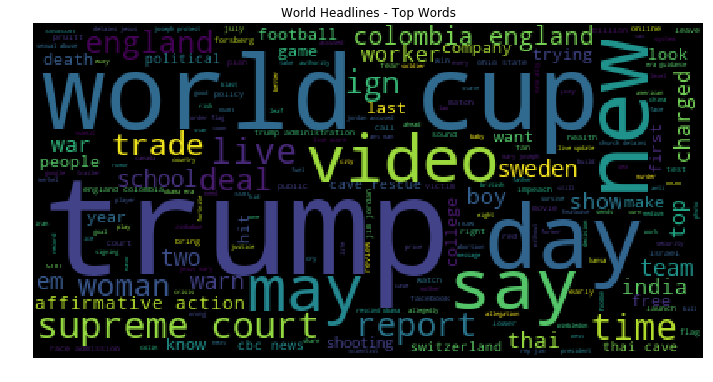

In [105]:
generteWordCloud(generateCleanWordsFromTitles(world_headlines_df['title']), 
                 "World Headlines - Top Words", 
                 'World-WordCloud')

## Top Words from US Headlines

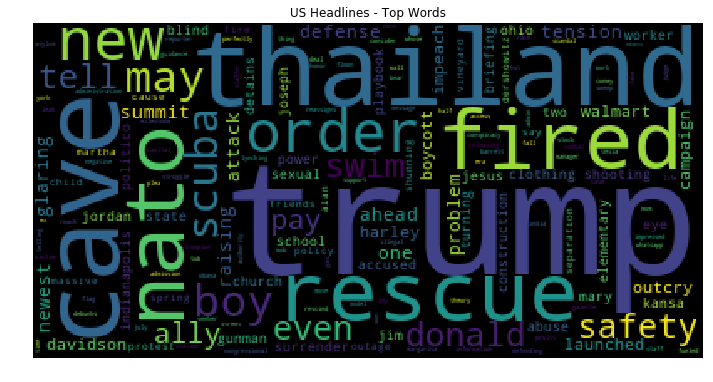

In [106]:
generteWordCloud(generateCleanWordsFromTitles(us_headlines_df['title']), 
                 "US Headlines - Top Words", 
                 'US-WordCloud')

## Find the top 10 words in the world media today
## Generate word frequency

## Find the top 10 words in the US media today
## Generate word frequency

In [64]:
def generateWordFrequency(text_as_strings):
    #print(text_as_strings)
    tokens = text_as_strings.split(" ")
    
    freq = {}

    for i in tokens:
        
        if i in freq:
            freq[i] += 1
        else:
            freq[i] = 1
    
    return freq
    
#print(freq)

In [69]:
#generateCleanWordsFromTitles(world_headlines_df['title'])

In [74]:
#generateWordFrequency(world_headline_words)
w_wf = generateWordFrequency(generateCleanWordsFromTitles(world_headlines_df['title']))

In [75]:
#type(wf)

In [76]:
FreqDist.most_common(wf)[:20]

[('trump', 50),
 ('the', 40),
 ('world', 25),
 ('cup', 24),
 ('england', 23),
 ('2018', 20),
 ('live', 20),
 ('day', 18),
 ('court', 18),
 ('say', 16),
 ('colombia', 15),
 ('new', 15),
 ('cave', 15),
 ('video', 13),
 ('may', 13),
 ('thai', 13),
 ('supreme', 13),
 ('what', 12),
 ('report', 11),
 ('time', 11)]

In [79]:
us_wf = generateWordFrequency(generateCleanWordsFromTitles(us_headlines_df['title']))

In [80]:
FreqDist.most_common(us_wf)[:20]

[('trump', 6),
 ('thailand', 2),
 ('cave', 2),
 ('rescue', 2),
 ('nato', 2),
 ('fired', 2),
 ('order', 2),
 ('', 1),
 ('boy', 1),
 ('may', 1),
 ('scuba', 1),
 ('safety', 1),
 ('even', 1),
 ('swim', 1),
 ('donald', 1),
 ('tell', 1),
 ('ally', 1),
 ('pay', 1),
 ('defense', 1),
 ('raising', 1)]

## Getting Sentiment Analysis for Headlines 
**Sentiment Analysis** <br/>
*Using vaderSentiment Analyzer to analize the new media sentiment from the headline*

### getSentiments Method
### Input: Dataframe returned by getCurrentHeadlines() call
### Return: sentiment list
#### Sentiment parameters
    "Headlines", 
    "Channel",
    "Compound",
    "Positive",
    "Negative",
    "Neutral"

In [19]:
def getSentiments(df):
    sentiments = []

    for index, row in df.iterrows():

        words = preprocessing(row['title'])

        # Run Vader Analysis on each headline
        results = analyzer.polarity_scores(words)
        compound = results["compound"]
        pos = results["pos"]
        neu = results["neu"]
        neg = results["neg"]

        # Add sentiments for each tweet into a list
        sentiments.append({"Headlines": row['title'], 
                           "Channel": row['News Channel'],
                           "Compound": compound,
                           "Positive": pos,
                           "Negative": neu,
                           "Neutral": neg})
        
    return sentiments

## Sentiment Analysis from World Headlines

In [113]:
world_sentiment_df = pd.DataFrame(getSentiments(world_headlines_df[:20]))

In [114]:
world_sentiment_df

,Channel,Compound,Headlines,Negative,Neutral,Positive
0,The Sport Bible,0.4215,From Gangs To Goals: How Football Saved Englan...,0.763,0.000,0.237
1,The Jerusalem Post,0.3612,Does 'Toy' sound like 'Seven Nation Army'?,0.706,0.000,0.294
2,The Jerusalem Post,-0.8625,Israel declares war on PA funding for terroris...,0.411,0.589,0.000
3,The Jerusalem Post,0.2500,Report: Shin Bet restores security for Barak a...,0.455,0.197,0.348
4,The Jerusalem Post,0.0000,PM at Protective Edge memorial: ‘There is no ...,1.000,0.000,0.000
5,The Jerusalem Post,-0.1027,PA warns against holding Eurovision in Jerusalem,0.682,0.318,0.000
6,The Jerusalem Post,-0.7430,Israel gets Twitter to block terror accounts,0.388,0.612,0.000
7,The Jerusalem Post,-0.6597,Mother of lost soldier to 'Post': We hear only...,0.526,0.474,0.000
8,Buzzfeed,-0.7906,Twitter Is At War Over The Correct Way To Pron...,0.588,0.412,0.000
9,Daily Mail,0.4767,British diver's mother reveals how proud late ...,0.693,0.000,0.307


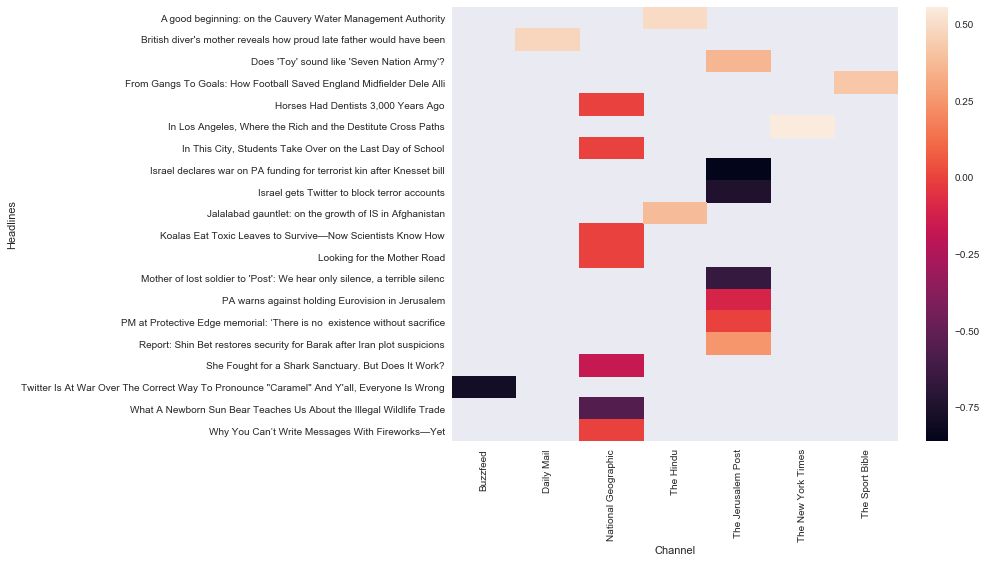

In [125]:
#sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.figure(figsize=(10,8))
world_sentiment_heatmap = world_sentiment_df.pivot_table(values='Compound',index='Headlines',columns='Channel')
world_sentiment_hp_fig = sns.heatmap(world_sentiment_heatmap)
world_sentiment_hp_fig.get_figure().savefig("World-Sentiment=HeatMap.png")

## Sentiment Analysis from US Headlines

In [117]:
us_sentiment_df = pd.DataFrame(getSentiments(us_headlines_df))
us_sentiment_df

,Channel,Compound,Headlines,Negative,Neutral,Positive
0,USA Today,0.7269,Thailand cave rescue: Boys may have to scuba t...,0.534,0.000,0.466
1,USA Today,-0.2960,Donald Trump tells NATO allies to pay more for...,0.606,0.280,0.114
2,Business Insider,-0.7003,There's one glaring problem with Trump's newes...,0.508,0.492,0.000
3,Fox News,-0.6249,Walmart boycott campaign launched after outcry...,0.360,0.505,0.135
4,Nydailynews.com,0.0000,Gunman surrenders after shooting two construct...,1.000,0.000,0.000
5,Politico,-0.8442,POLITICO Playbook Power Briefing: Jim Jordan a...,0.547,0.453,0.000
6,NBC News,-0.2500,"Indianapolis church 'detains' Jesus, Mary and ...",0.818,0.182,0.000
7,Cbslocal.com,-0.3400,Spring Fire Causes Massive 911 Outage,0.676,0.324,0.000
8,The Washington Post,0.4767,Alan Dershowitz says 'friends on Martha's Vine...,0.721,0.000,0.279
9,The Washington Post,-0.7845,Ex-congressional IT staffer reaches plea deal ...,0.497,0.435,0.068


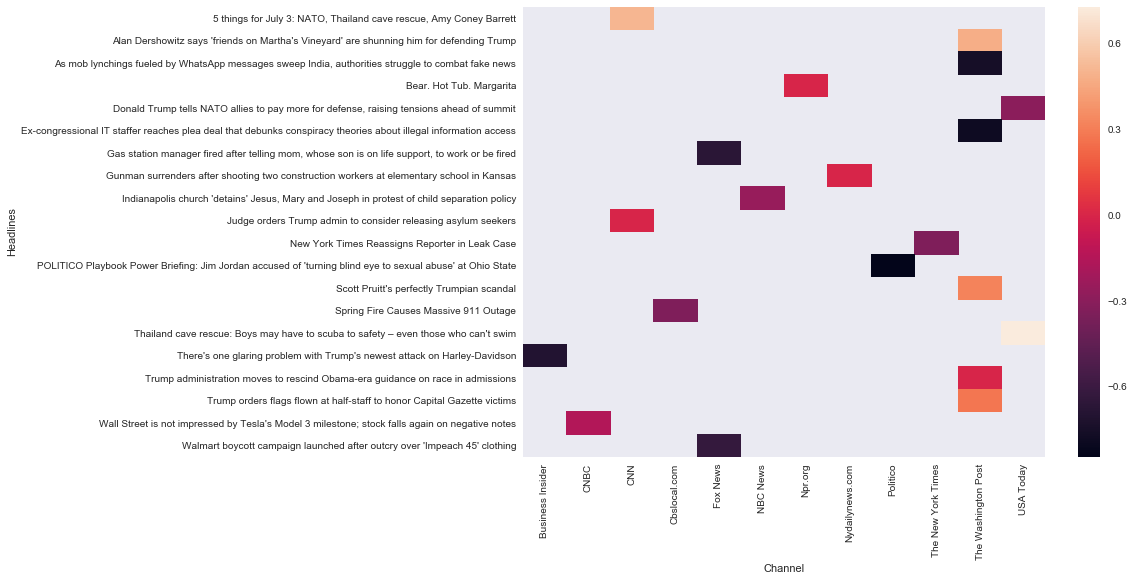

In [119]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
us_sentiment_heatmap = us_sentiment_df.pivot_table(values='Compound',index='Headlines',columns='Channel')
us_sentiment_hp_fig = sns.heatmap(us_sentiment_heatmap)
us_sentiment_hp_fig.get_figure().savefig("US-Sentiment=HeatMap.png")